# ZERO INFLATED MODEL
Bs Vương Kiến Thanh

## TỔNG QUAN
Zero inflated model dùng để mô hình hoá dữ liệu mà trong đó dư thừa con số không. Chúng ta thường gặp nhất là dữ liệu số đếm dư thừa số không, các con số đếm đến từ các tiến trình Poisson, tạo thành phân phối Zero inflated Poisson.

Cụ thể, tiến tình tạo ra con số không (zero) đến từ hai nguồn:
1. Phân phối Bernoulli: tạo ra số 0 và 1.
2. Phân phối Poisson: khi pp binom (trên) tạo ra 1, thì biến kết cục (outcome) cho zero. Còn khi pp binom tạo ra 0, thì nó đi tiếp đến pp Poisson và cho một số đếm bất kỳ (cũng có thể là zero hoặc cao hơn).

Do đó, số không sẽ bị dư thừa (hay *zero inflated*).

Định dạng toán học của Zero inflated Poisson model:

$$ \begin{aligned}
y &\sim \text{ZeroInflatedPoisson}(p, \lambda)\\
\text{logit}(p) &\sim \text{linear model 1}\\
\log(\lambda) &\sim \text{linear model 2}\\
\end{aligned}$$

Kết cục ($y$) có hàm khối xác suất (PMF):

$$p(y_n \mid p,\lambda)
=
\begin{cases}
p + (1 - p) \times \textsf{Poisson}(0 \mid \lambda) & \quad\text{if } y_n = 0, \text{ and}\\
(1-p) \times \textsf{Poisson}(y_n \mid \lambda) &\quad\text{if } y_n > 0.
\end{cases}$$

## Thực hành

Source: https://stats.idre.ucla.edu/stata/dae/zero-inflated-poisson-regression/

Chúng ta có 250 nhóm người vào câu cá. Mỗi nhóm được thu thập ý định câu cá (`nofish`), số cá họ thu được (`count`), số trẻ em trong nhóm (`child`), và số người trong nhóm (`persons`), và họ có cắm trại không (`camper`).

In [1]:
import arviz as az
import matplotlib.pyplot as plt

import pandas as pd
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, log_likelihood, MCMC, NUTS

In [2]:
df = pd.read_csv('https://stats.idre.ucla.edu/stat/data/fish.csv')
df

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1
...,...,...,...,...,...,...,...,...
245,1,1,1,2,0,-0.755236,2.324209,0
246,0,1,1,4,3,1.794859,-5.625944,0
247,0,1,1,2,1,-0.392649,0.677275,0
248,1,1,1,3,2,1.374641,-2.595630,0


In [3]:
# helper functions
data_w = {
    'nofish' :df['nofish'].values,
    'camper' :df['camper'].values,
    'persons':df['persons'].values,
    'child'  :df['child'].values,
    'count'  :df['count'].values
}
data_wo = {
    'camper' :df['camper'].values,
    'persons':df['persons'].values,
    'child'  :df['child'].values,
    'count'  :df['count'].values
}
pred_data_w = {
    'nofish' :df['nofish'].values,
    'camper' : df['camper'].values,
    'persons':df['persons'].values,
    'child'  :df['child'].values,
}

pred_data_wo = {
    'camper' : df['camper'].values,
    'persons':df['persons'].values,
    'child'  :df['child'].values,
}
def plot_fit(model, w=True):
    data = pred_data_w if w else pred_data_wo
    pred = Predictive(
        model.sampler.model,
        model.get_samples())(random.PRNGKey(1), **data)
    plt.hist(df['count'], bins=jnp.arange(30),label='real count')
    plt.hist(jnp.mean(pred['count'],0), bins=jnp.arange(30), alpha=0.7,label="predicted count")
    plt.legend()

### Poisson
Vì `count` là số đếm, nên chúng ta có thể dùng Poisson GLM, với các hiệp biến là: `nofish`, `camper`, `persons` và `child`.

In [4]:
def model(nofish,camper, persons, child, count=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bnf = numpyro.sample("bnf", dist.Normal(0,1))
    bca = numpyro.sample("bca", dist.Normal(0,1))
    bpe = numpyro.sample('bpe', dist.Normal(0,1))
    bch = numpyro.sample("bch", dist.Normal(0,1))
    lambda_ = jnp.exp(a + bnf*nofish + bca*camper + bpe*persons + bch*child)
    numpyro.sample("count", dist.Poisson(lambda_), obs=count)


poisson = MCMC(NUTS(model), 500, 2000, num_chains=4, chain_method='sequential')
poisson.run(random.PRNGKey(0),**data_w)
poisson.print_summary(0.89)

sample: 100%|██████████| 2500/2500 [00:05<00:00, 499.34it/s, 31 steps of size 1.77e-01. acc. prob=0.93]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -1.64      0.15     -1.64     -1.88     -1.40   4478.89      1.00
       bca      0.78      0.09      0.78      0.64      0.92   5251.64      1.00
       bch     -1.69      0.08     -1.69     -1.82     -1.55   6063.04      1.00
       bnf     -1.01      0.11     -1.00     -1.18     -0.84   6404.06      1.00
       bpe      1.08      0.04      1.08      1.02      1.14   4903.19      1.00

Number of divergences: 0


#### Kiểm tra fit

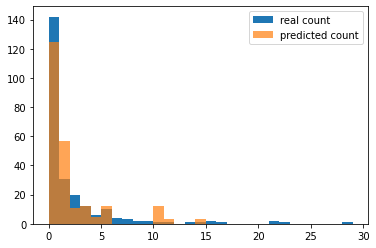

In [5]:
plot_fit(poisson)

Tuy nhiên, nhìn vào `real count`, ta thấy kết cục tập trung nhiều ở zero.

Sự dư thừa zero này có thể do biến số *ý định đi câu cá* (`nofish`). Khi nhóm không có ý định câu cá, thì kết cục `count` là zero. Khi nhóm có ý định câu cá, thì họ có thể không câu được câu được một vài con.

Nếu chúng ta có thêm biến *ý định đi câu cá*, tức là mô hình Poisson ở trên.

Nhưng giả sử trong trường hợp chúng ta không có thu thập biến số đó. Thì Poisson không có biến đó sẽ có fit kém hơn:

In [6]:
def model(camper, persons, child, count=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bca = numpyro.sample("bca", dist.Normal(0,1))
    bpe = numpyro.sample('bpe', dist.Normal(0,1))
    bch = numpyro.sample("bch", dist.Normal(0,1))
    lambda_ = jnp.exp(a + bca*camper + bpe*persons + bch*child)
    numpyro.sample("count", dist.Poisson(lambda_), obs=count)
poisson_wo = MCMC(NUTS(model), 500, 2000, num_chains=4, chain_method='sequential')
poisson_wo.run(random.PRNGKey(0),**data_wo)
poisson_wo.print_summary(0.89)

sample: 100%|██████████| 2500/2500 [00:05<00:00, 491.94it/s, 15 steps of size 1.56e-01. acc. prob=0.94]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -1.93      0.15     -1.93     -2.17     -1.70   3427.81      1.00
       bca      0.91      0.09      0.91      0.77      1.05   4621.03      1.00
       bch     -1.68      0.08     -1.68     -1.81     -1.56   4945.21      1.00
       bpe      1.08      0.04      1.08      1.02      1.14   3433.76      1.00

Number of divergences: 0


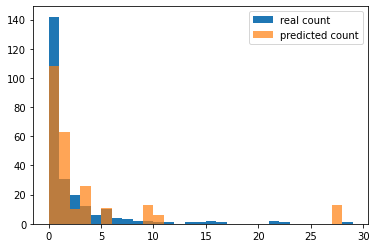

In [7]:
plot_fit(poisson_wo, w=False)

### Zero inflated
Một phương pháp dùng được trong trường hợp này là Zero inflated Poisson.

Ở đây, mô hình là:

$$ \begin{aligned}
y &\sim \text{ZeroInflatedPoisson}(p, \lambda)\\
\text{logit}(p) &\sim \alpha\\
\log(\lambda) &\sim \alpha + \beta X && X = {\text{persons, camper, child}}\\
\end{aligned}$$

In [8]:
def model(camper, persons, child, count=None):
    ap = numpyro.sample("ap", dist.Normal(0, 1))
    p = expit(ap)
    al = numpyro.sample("al", dist.Normal(0, 1))
    bpe = numpyro.sample("bpe", dist.Normal(0, 1))
    bca = numpyro.sample("bca", dist.Normal(0,1))
    bch = numpyro.sample("bch", dist.Normal(0,1))
    lambda_ = jnp.exp(al + bpe*persons + bca*camper + bch*child)
    numpyro.sample("count", dist.ZeroInflatedPoisson(p, lambda_), obs=count)
inflated = MCMC(NUTS(model), 500, 2000, num_chains=4, chain_method='sequential')
inflated.run(random.PRNGKey(2),**data_wo)
inflated.print_summary(0.89)

sample: 100%|██████████| 2500/2500 [00:04<00:00, 521.47it/s, 15 steps of size 1.57e-01. acc. prob=0.94]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al     -0.97      0.17     -0.96     -1.22     -0.67   3547.21      1.00
        ap     -0.35      0.18     -0.34     -0.61     -0.04   5350.88      1.00
       bca      0.78      0.09      0.79      0.63      0.93   5399.49      1.00
       bch     -1.35      0.10     -1.35     -1.50     -1.20   5365.93      1.00
       bpe      0.86      0.04      0.86      0.79      0.93   3833.24      1.00

Number of divergences: 0


#### Trả lời các câu hỏi:
1. Xác suất không có ý định câu cá là:

In [9]:
expit(inflated.get_samples()['ap'].mean())

DeviceArray(0.41437423, dtype=float32)

2. Dự đoán ngược vào data (kiểm tra fit)

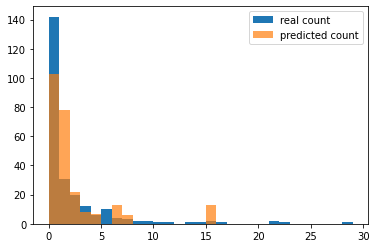

In [10]:
plot_fit(inflated, w=False)

3. Diễn giải các hệ số beta thì khó hơn. Để minh hoạ hiệu ứng của số lượng trẻ em trong nhóm lên số cá câu được, chúng ta có thể đặt những hiệp biến khác bằng 0, và thử các giá trị của `child`.

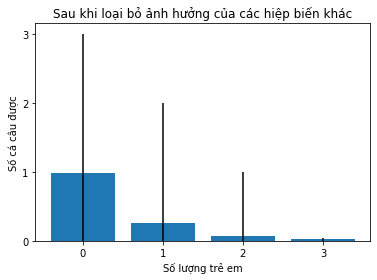

In [11]:
lambdas = jnp.exp(jnp.outer(inflated.get_samples()['bch'], jnp.arange(4)))

counts = numpyro.sample(
    'count',
    dist.Poisson(lambdas),
    rng_key=random.PRNGKey(1)
)
means = jnp.mean(counts, axis=0)
cis = jnp.quantile(counts, q=jnp.array([0.025,0.975]), axis=0)
plt.bar(range(4), means, yerr=jnp.abs(cis-means))
plt.gca().set(xticks=range(4), yticks=range(4),
              xlabel='Số lượng trẻ em', ylabel='Số cá câu được',
              title='Sau khi loại bỏ ảnh hưởng của các hiệp biến khác');

Như vậy, số lượng trẻ em tương quan âm với số cá câu được. Diễn giải các hiệp biến khác cũng có thể được thực hiện tương tự. 

### So sánh các mô hình
Tôi cũng fit thêm mô hình được dùng trong bài gốc ở trên:

In [12]:
def model(camper, persons, child, count=None):
    ap = numpyro.sample("ap", dist.Normal(0, 1))
    ape = numpyro.sample('ape', dist.Normal(0,1))
    p = expit(ap + ape*persons)
    al = numpyro.sample("al", dist.Normal(0, 1))
    aca = numpyro.sample("aca", dist.Normal(0,1))
    ach = numpyro.sample("ach", dist.Normal(0,1))
    lambda_ = jnp.exp(al + aca*camper  + ach*child)
    numpyro.sample("count", dist.Poisson(lambda_), obs=count)

src = MCMC(NUTS(model), 500, 2000, num_chains=4, chain_method='sequential')
src.run(random.PRNGKey(0),**data_wo)

sample: 100%|██████████| 2500/2500 [00:04<00:00, 550.78it/s, 15 steps of size 3.22e-01. acc. prob=0.95]


In [13]:
azdata = az.from_numpyro(poisson)
azdata2 = az.from_numpyro(poisson_wo)
azdata3 = az.from_numpyro(inflated)
azdata4 = az.from_numpyro(src)
comp = az.compare({'poisson':azdata,
                   'poisson_wo':azdata2,
                   'inflated':azdata3,
                   'source':azdata4})
comp.style.set_precision(3)

/Volumes/DATA/anaconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Volumes/DATA/anaconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Volumes/DATA/anaconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less lik

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
inflated,0,-815.296,70.792,0.000,0.443,178.411,0.000,True,log
poisson,1,-822.112,65.205,6.816,0.376,166.795,47.865,True,log
poisson_wo,2,-873.365,63.637,58.068,0.000,186.088,27.287,True,log
source,3,-1394.498,65.286,579.201,0.181,358.931,204.157,True,log


Ở đây, `loo` (leave-one-out cross validation, ước lượng bằng PSIS) cho rằng mô hình `inflated` là tốt nhất, rồi đến `poisson`, `poisson_wo`, `source`.

Chú ý rằng chúng ta cần phải suy luận thêm khoảng tin cậy của `loo` thông qua `d_loo`, `se`, `dse`. Để minh hoạ rõ hơn:

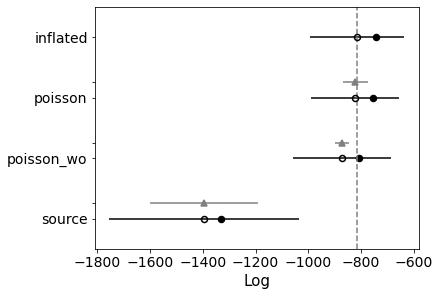

In [14]:
az.plot_compare(comp);

Mặc dù `inflated` là mô hình tốt nhất, nhưng nó khác biệt không có ý nghĩa so với `poisson`, `poisson_wo`. Mô hình `source` kém nhất và khác xa với 3 mô hình trên. Sự khác biệt không có ý nghĩa giữa mô hình `inflated` (không có biến `nofish`) và mô hình `poisson` (có `nofish`) nói lên sức mạnh của zero inflated poisson.

### Outliers
Khác với các tiếp cận tìm outlier khác, `loo` cho phép chúng ta tìm ra những điểm dữ liệu nào có ảnh hưởng lớn đến suy luận sau khi đã fit mô hình vào data.

In [15]:
loo = az.loo(azdata, pointwise=True)
loo2 = az.loo(azdata2, pointwise=True)
loo3 = az.loo(azdata3, pointwise=True)
pd.concat([
    df.iloc[loo.pareto_k.data>0.7],
    df.iloc[loo2.pareto_k.data>0.7],
    df.iloc[loo3.pareto_k.data>0.7]
]).drop_duplicates()

/Volumes/DATA/anaconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Volumes/DATA/anaconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Volumes/DATA/anaconda3/envs/jupyter/l

,nofish,livebait,camper,persons,child,xb,zg,count
88,0,1,1,4,0,5.005040,3.572134,149
137,0,1,0,3,1,3.726073,0.701675,31
178,1,1,1,2,0,3.053917,2.469108,21


Thực vậy, dữ liệu ở dòng 88 cho số lượng cá câu được rất cao một cách ngạc nhiên. Điểm dữ liệu dòng 137 có thể do `camper=0` mà lại có `count` lớn. Điểm dữ liệu dòng 178 có thể do `nofish=1` mà lại có `count` lớn. Chúng ta có thể cảm nhận gián tiếp bằng trực quan qua:

In [16]:
df[df['count']>20]

,nofish,livebait,camper,persons,child,xb,zg,count
24,0,1,1,3,0,3.500298,1.451271,30
41,0,1,1,4,0,3.484046,2.355653,32
52,0,1,1,4,0,3.196706,1.515483,22
63,0,1,1,4,0,3.489336,2.547997,32
88,0,1,1,4,0,5.005040,3.572134,149
99,0,1,0,4,0,3.594677,0.860209,29
137,0,1,0,3,1,3.726073,0.701675,31
159,0,1,1,4,0,4.268488,1.362296,65
178,1,1,1,2,0,3.053917,2.469108,21
199,0,1,1,2,0,3.163843,1.296835,21


## Kết luận:
Trong trường hợp tiến tình tạo kết cục bị dư thừa zero bởi phân phối Bernoulli, chúng ta có thể dùng Zero inflated Distribution. Bài hôm nay dùng zero inflated Poisson. Nhưng bạn cũng có thể dùng Base distribution khác như gamma, negative binom,.. chỉ cần có kết cục zero là ứng dụng được.

Reference:
- https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html
- https://stats.idre.ucla.edu/stata/dae/zero-inflated-poisson-regression/